In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
api_key = "WFHZHJATQIO0HDH7"

In [4]:
def get_stocks(equity):
    base_url = "https://www.alphavantage.co/query?"
    url = base_url + 'function=TIME_SERIES_INTRADAY' + '&symbol=' + equity + '&interval=5min&extended_hours=true&apikey=' + api_key
    response = requests.get(url)
    if response.status_code == 200:
        df = pd.DataFrame(response.json())
        return df
    else:
        print("Could not fetch data")
        return

In [5]:
def get_time_series(stocks):
    return stocks[6:]

In [6]:
def plot_stocks(time_data, time_stamp):
    open = []
    high = []
    low = []
    close = []
    volume = []
    for i in time_data:
        open.append(i['1. open'])
        high.append(i['2. high'])
        low.append(i['3. low'])
        close.append(i['4. close'])
        volume.append(i['5. volume'])
    date = []
    time = []
    for i in time_stamp:
        date.append(i[0:11])
        time.append(i[11:])
    x = time
    plt.figure(figsize=(50, 30))
    plt.plot(x, close, label="Close", marker="s")
    plt.xlabel(date[0])
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    
    plt.show()

In [7]:
def main():
    equity = input("Enter equity id: ")
    raw_stocks = get_stocks(equity.upper())
    time_series = get_time_series(raw_stocks)
    time_stamp = time_series.index
    time_data = time_series['Time Series (5min)'].to_numpy()
    plot_stocks(time_data[::-1], time_stamp[::-1])


    

## Top 20 Most Famous Equities

| Equity Name          | Symbol | Sentiment |
|----------------------|--------|-----------|
| Apple Inc.          | AAPL   | Positive  |
| Microsoft Corp.     | MSFT   | Positive  |
| Amazon.com Inc.     | AMZN   | Positive  |
| Alphabet Inc. (GOOGL)| GOOGL | Positive  |
| Alphabet Inc. (GOOG) | GOOG  | Positive  |
| Tesla Inc.          | TSLA   | Negative  |
| Meta Platforms Inc. | META   | Positive  |
| NVIDIA Corp.        | NVDA   | Positive  |
| Berkshire Hathaway  | BRK.B  | Positive  |
| JPMorgan Chase & Co.| JPM    | Positive  |
| Johnson & Johnson   | JNJ    | Negative  |
| Visa Inc.          | V      | Positive  |
| Procter & Gamble   | PG     | Positive  |
| UnitedHealth Group | UNH    | Negative  |
| Exxon Mobil Corp.  | XOM    | Negative  |
| The Walt Disney Co.| DIS    | Positive  |
| Netflix Inc.       | NFLX   | Positive  |
| Adobe Inc.         | ADBE   | Positive  |
| PayPal Holdings Inc.| PYPL  | Negative  |
| Intel Corp.        based on market trends._


Enter equity id:  XOM


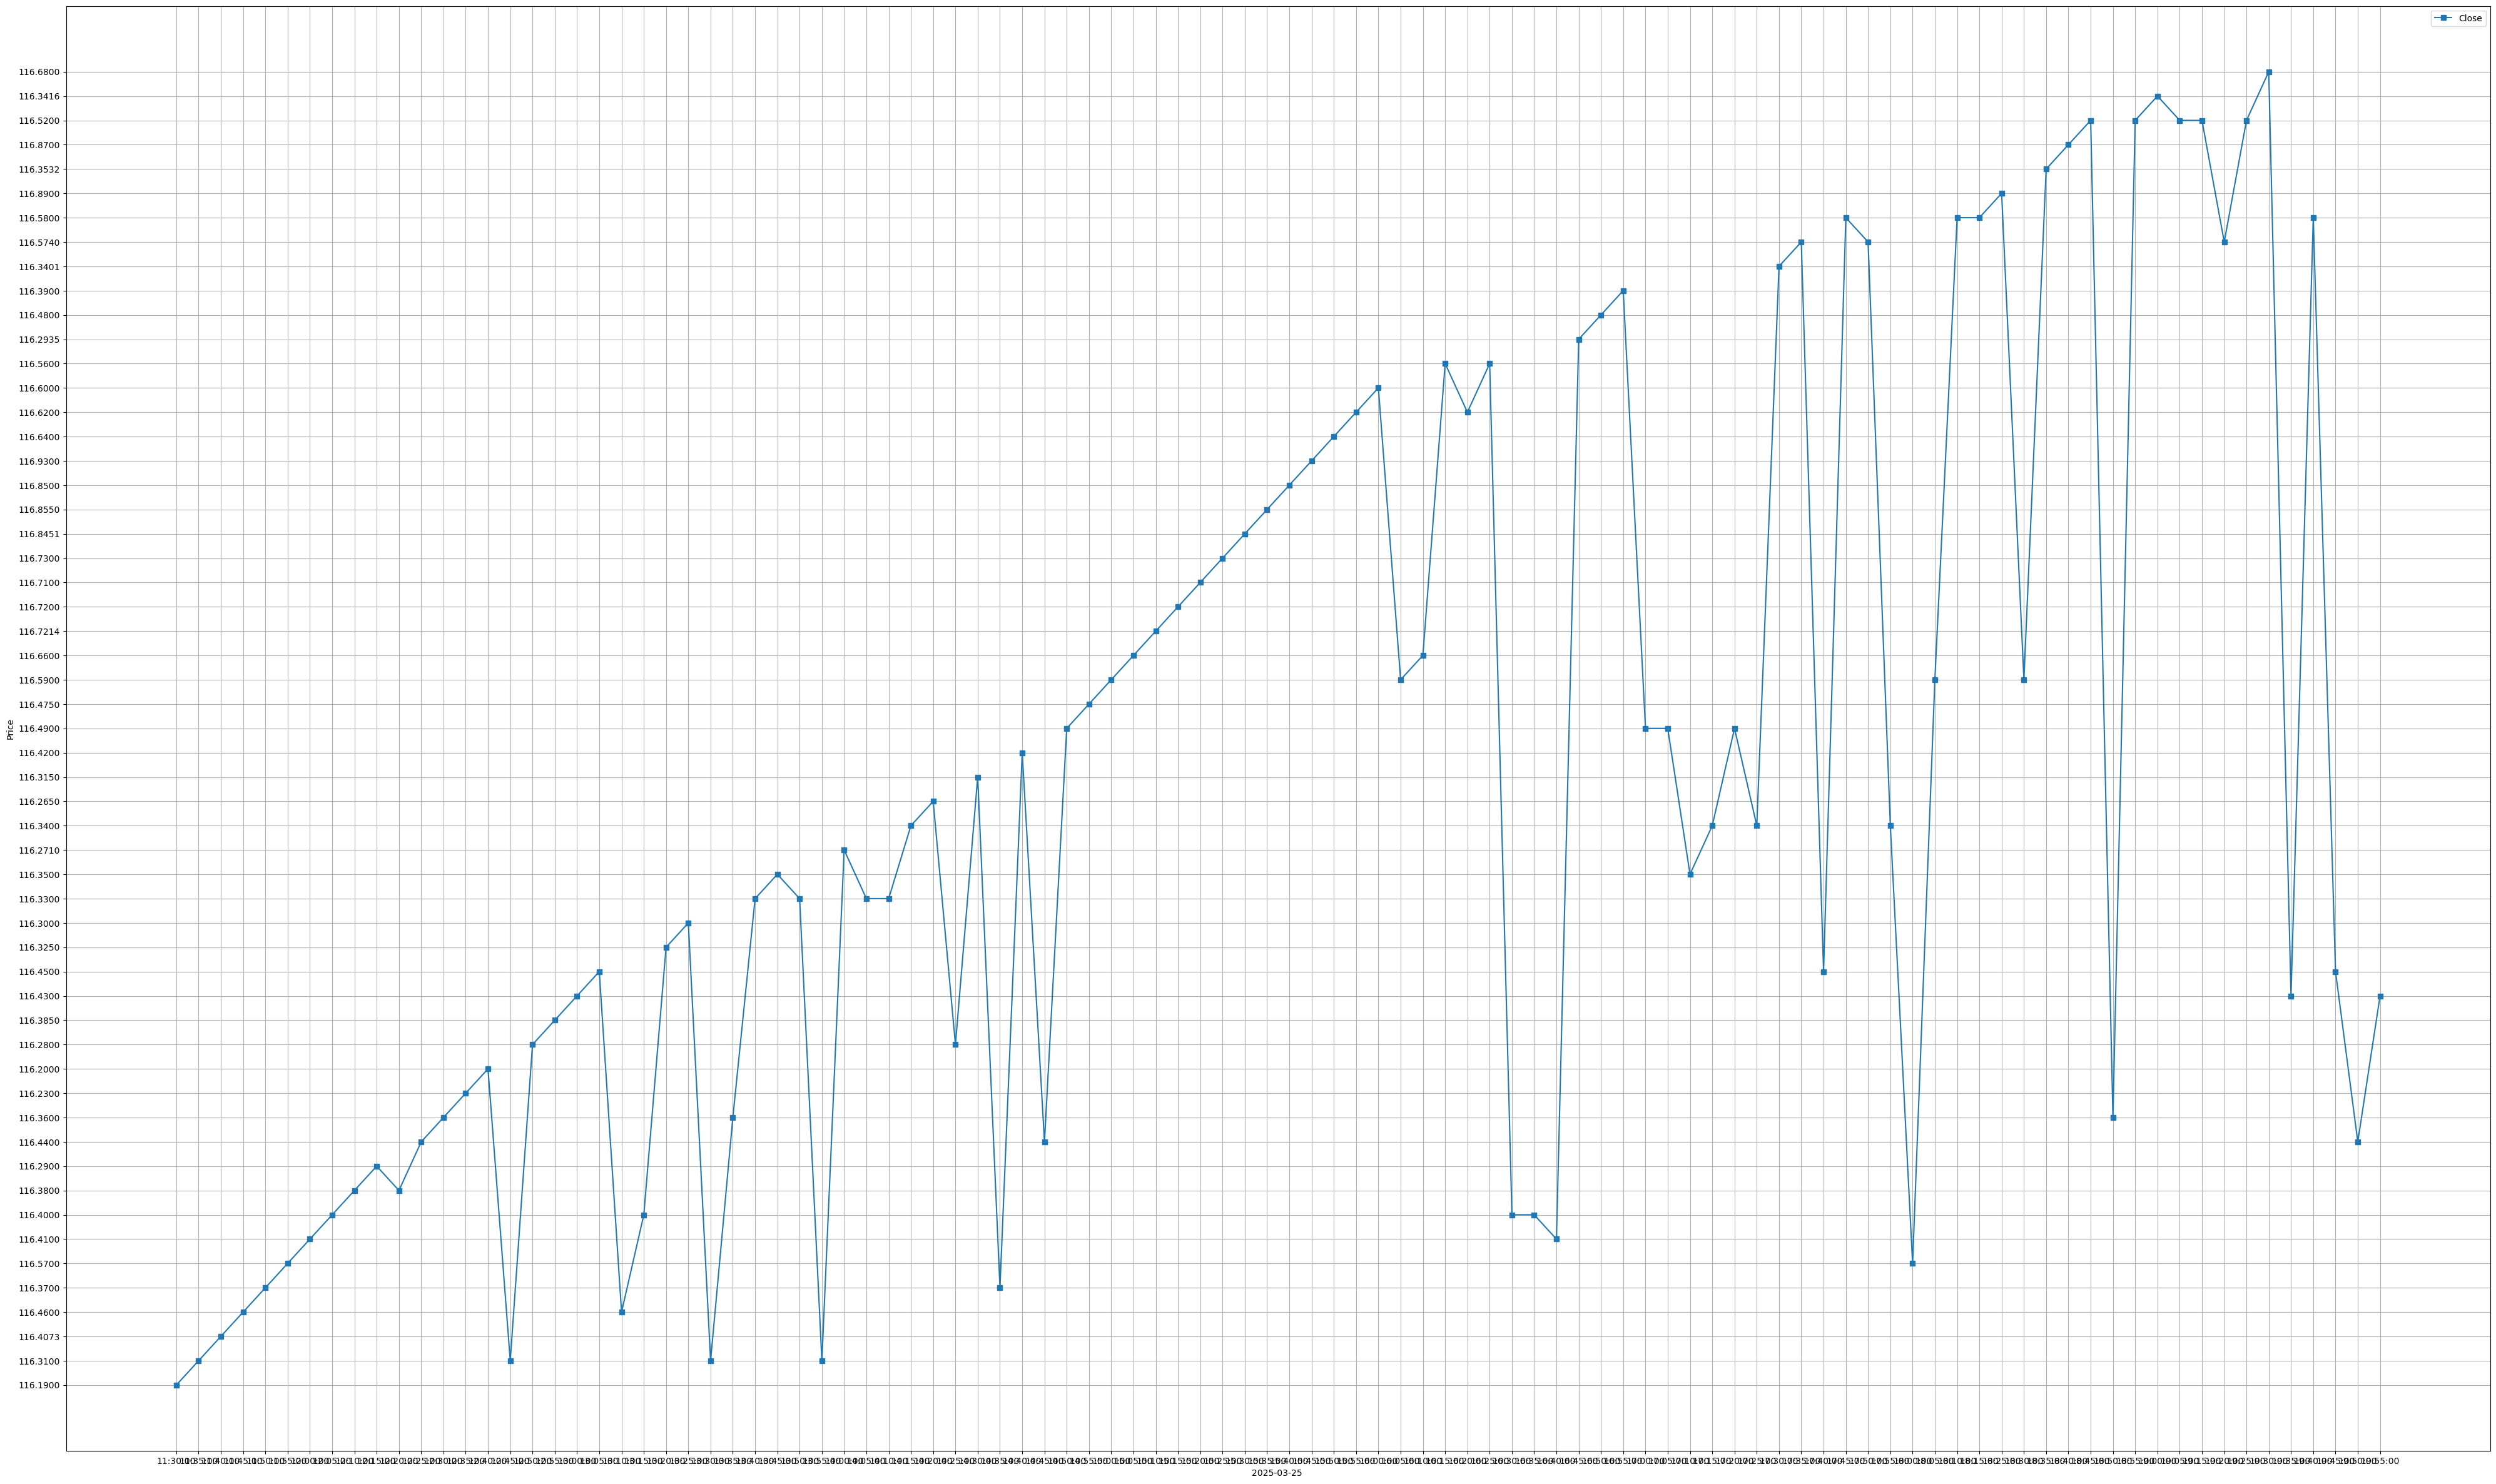

In [10]:
main()